## Required Assignment 11.1: What Drives the Price of a Car?


**Overview**

In this application, we will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure the speed of processing .Our goal is to understand what factors make a car more or less expensive. As a result of our analysis, we should provide clear recommendations to our client—a used car dealership—as to what consumers value in a used car.

To frame the task, throughout these practical applications, we will refer to a standard process in the industry for data projects called CRISP-DM. This process provides a framework for working through a data promblem.

<a id="top"></a>

## Table of Contents
1. [Business Understanding](#1.-Business-Understanding)
2. [Data Understanding](#2.-Data-Understanding) 
3. [Data Preparation](#3.-Data-Preparation)
4. [Modeling](#4.-Modeling)
5. [Evaluation](#5.-Evaluation)
6. [Deployment](#6.-Deployment)
7. [Recommendation](#7.-Recommendation)

## CRISP-DM Framework Project


### 1. Business Understanding
The project objective is to advise car dealerships on what features are most important to consumers for used cars and offer insights glean from the data to make recommendations on how best to optimize their inventory.

### 2. Data Understanding
Let's begin with the aim to understand the data. After loading the vehicles.csv dataset, we look at its shape to determined how many rows (~426k) there are and further information helps us see how many features (18) there are possible. We can also derived which ones are categorical in nature ('condition', 'year', 'fuel', 'size', 'drive', etc) versus continuous (price, milage, etc). Previewing the top five will give us a better comprehension of the data involved with one of the first thing we notice is there are a lot of missing values. Noting the columns with few missing values, some of the possible candidates for modeling would be- manufacturing, model, odometer, fuel, and year (CRIS-DM accounts for the messiness of the real world by being an iterative process, and while not strictly adhering to the process, to keep things simple we went ahead and remove these the null values before continue our data exploration). After we'll look at the skewed distribution.    

In [ ]:
# if xgboost is not installed
# !pip install xgboost

In [95]:
# core libs
import numpy as np
import pandas as pd

# visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Scikit-Learn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score  
from xgboost import XGBRegressor

# presentation
from IPython.display import display, HTML

In [97]:
def load_data(file_path='../data/vehicles.csv'):
    data = pd.read_csv(file_path)
    return data

In [101]:
data = load_data()

num_rows = data.shape[0]
print(f"{num_rows:,} total rows")

data.info()

426,880 total rows
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null

In [103]:
styled_table = data.head().style.set_caption("First Five Rows of the Vehicle Dataset") \
    .set_table_styles(
        [{
            'selector': 'caption',
            'props': [
                ('caption-side', 'top'),
                ('text-align', 'left'),
                ('font-weight', 'bold'),
                ('font-size', '16px')
            ]
        }]
    )

styled_table

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,az
1,7218891961,fayetteville,11900,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,ar
2,7221797935,florida keys,21000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,fl
3,7222270760,worcester / central MA,1500,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,ma
4,7210384030,greensboro,4900,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nc


In [105]:
missing_counts = data.isnull().sum().sort_values(ascending=False)  # total number missing
missing_percent = data.isnull().mean().sort_values(ascending=False) * 100

missing_counts = missing_counts[missing_counts > 0]
missing_percent = missing_percent[missing_percent > 0].apply(lambda x: f"{x:.2f}%")

# creating 'Missing Count' formmatted column
html = """
<div style='display: flex; font-family: monospace;'>
  <div style='width: 50%; padding-right: 40px;'>
    <h4>Missing (by Total Count)</h4>
"""
for label, value in missing_counts.items():
    html += f"""
    <div style='display: flex; justify-content: space-between;'>
      <span>{label}</span>
      <span style='text-align: right;'>{value}</span>
    </div>
    """

# creating 'Missing Percent' formmatted column
html += """
  </div>
  <div style='width: 50%;'>
    <h4>Missing (by Percent)</h4>
"""

for label, value in missing_percent.items():
    html += f"""
    <div style='display: flex; justify-content: space-between;'>
      <span>{label}</span>
      <span style='text-align: right;'>{value}</span>
    </div>
    """

html += "</div></div>"

# Display formatted two-column output
display(HTML(html))

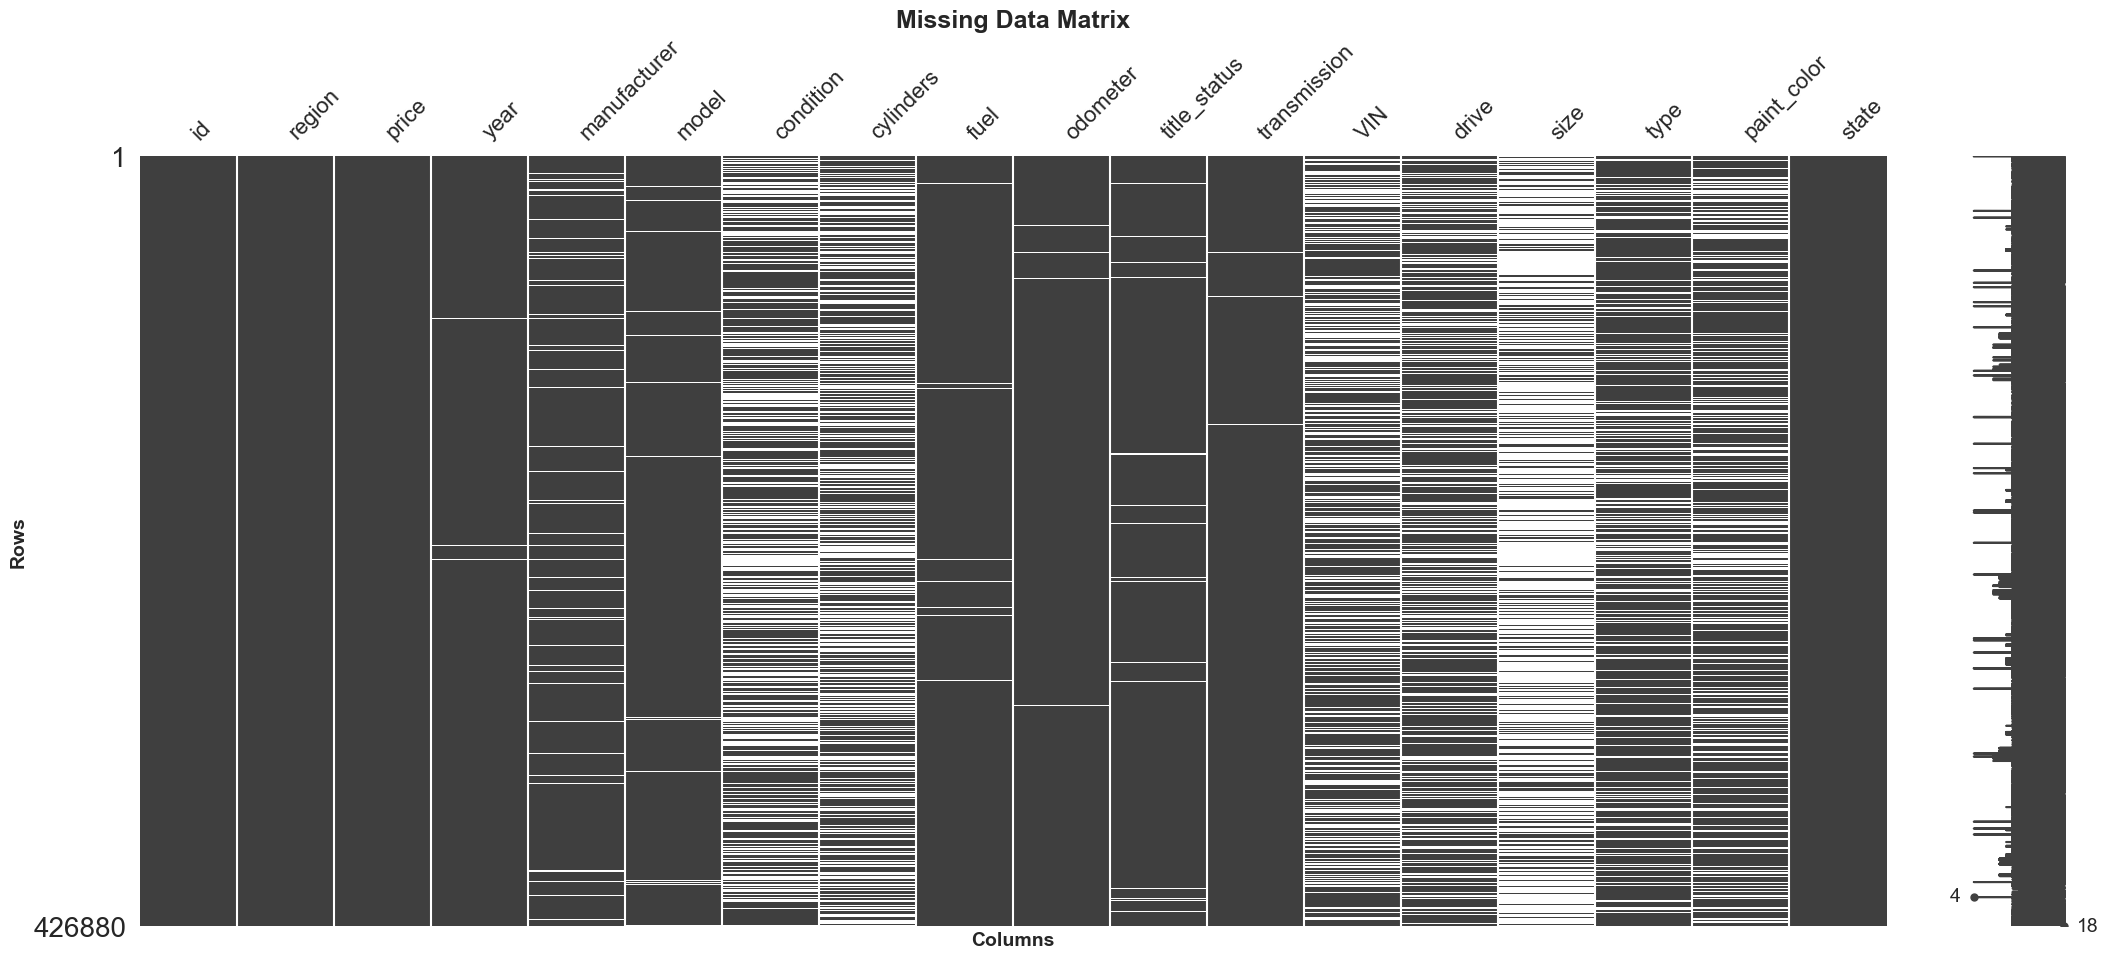

In [107]:
msno.matrix(data)
plt.title("Missing Data Matrix", fontsize=18, fontweight='bold')
plt.xlabel("Columns", fontsize=14, fontweight='bold')
plt.ylabel("Rows", fontsize=14, fontweight='bold')
plt.show()

[Back to Top](#top)

## 3. Data Preparation
Now that we have a clearer understanding of the data, its time to prep it starting with dropping the not useful (too sparse) columns that we discovered above with the two main candidates being 'size' and 'VIN' while keeping 'condition', 'cylinders', 'drive', 'type', 'and 'paint_color' and performing some sort of imputing on them. Then we'll take a look at it visually again before moving to modeling.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352279 entries, 0 to 352278
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         352279 non-null  int64  
 1   year          352279 non-null  float64
 2   manufacturer  352279 non-null  object 
 3   condition     352279 non-null  object 
 4   cylinders     352279 non-null  object 
 5   fuel          352279 non-null  object 
 6   odometer      352279 non-null  float64
 7   title_status  352279 non-null  object 
 8   transmission  352279 non-null  object 
 9   drive         352279 non-null  object 
 10  type          352279 non-null  object 
 11  state         352279 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 32.3+ MB


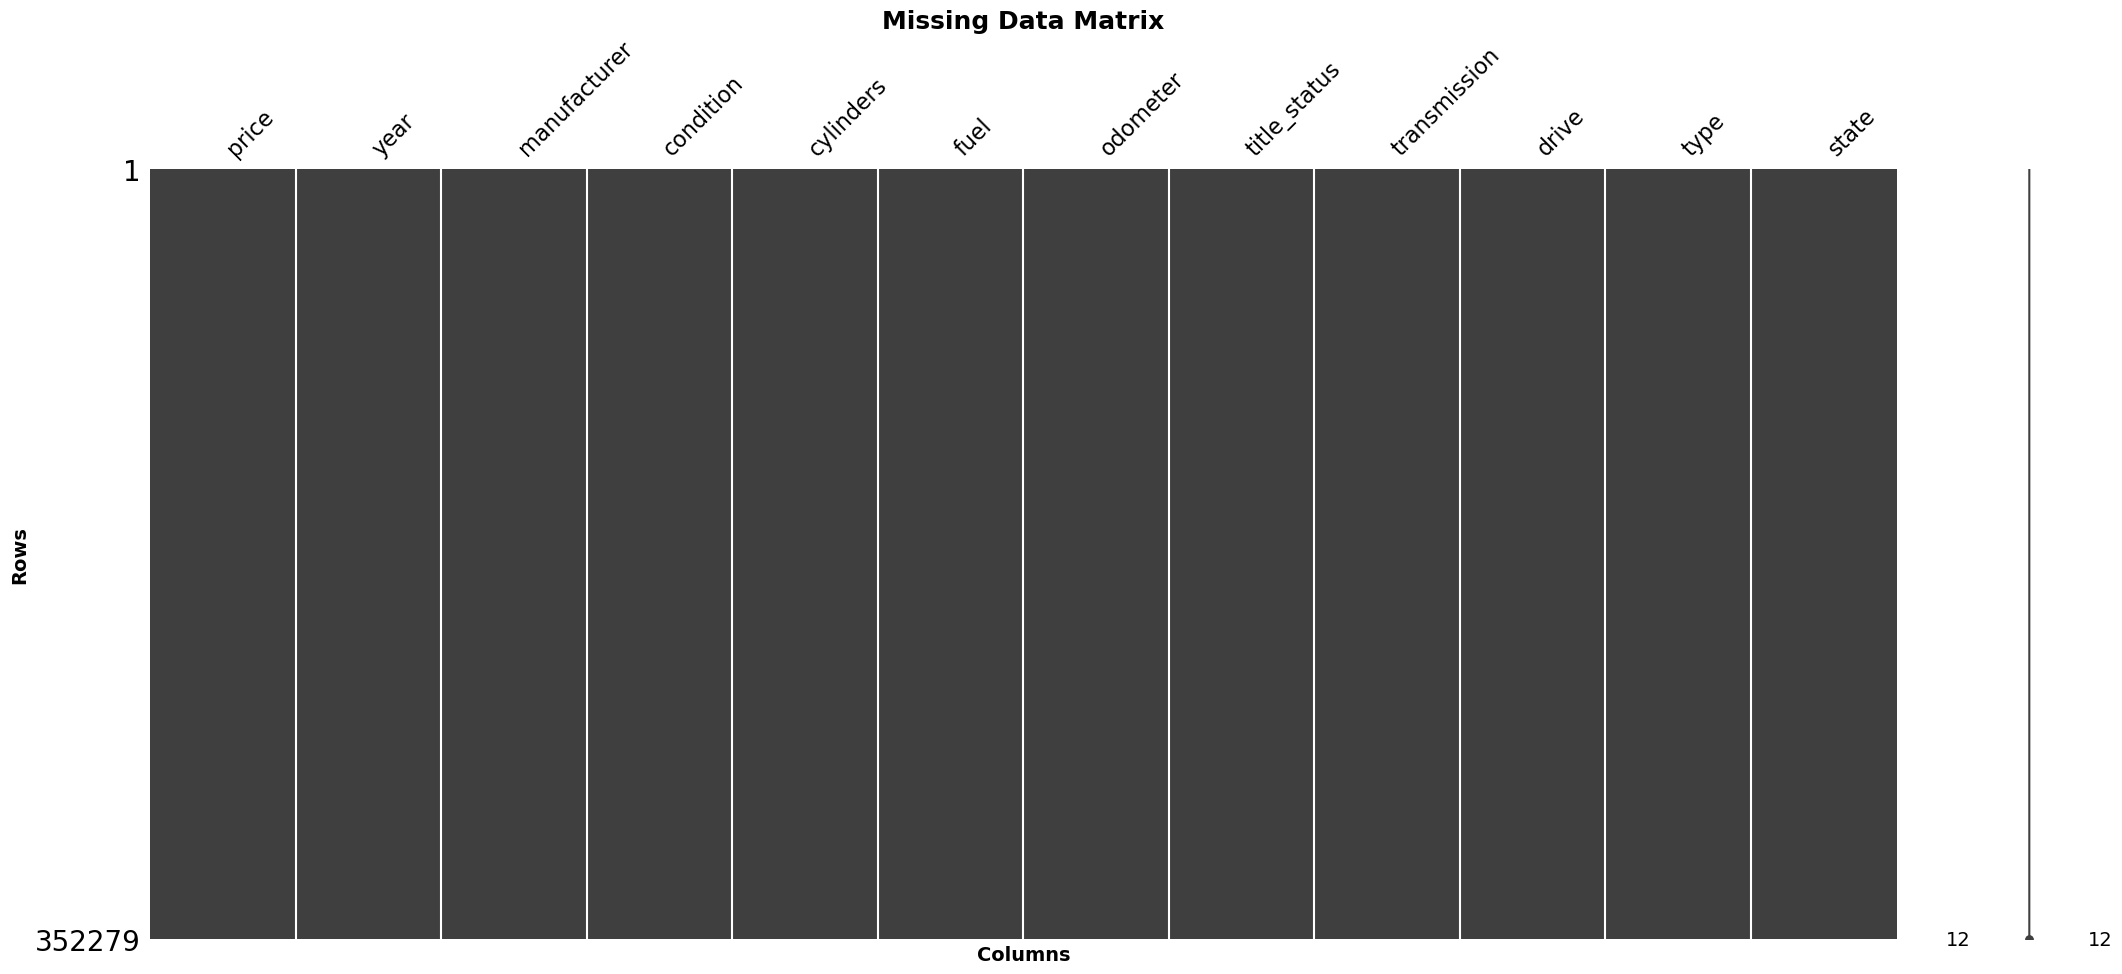

In [13]:
# Drop cols with missing values and/or not useful
data_clean = data.drop(columns=['id', 'size', 'VIN', 'region', 'paint_color', 'model'])

# add 'unknown' to the other missing values
categorical_cols = ['cylinders', 'condition', 'drive', 'type']
data_clean[categorical_cols] = data_clean[categorical_cols].fillna('unknown')

# drop rows with missing values 
required_cols = ['year', 'odometer', 'price', 'manufacturer', 'fuel', 'transmission', 'title_status']
data_clean = data_clean.dropna(subset=required_cols)

# Remove outliers in price and odometer
data_clean = data_clean[data_clean['price'].between(1000, 100000)]
data_clean = data_clean[data_clean['odometer'] <= 300000]

data_clean.reset_index(drop=True, inplace=True)

# taking another look
data_clean.info()

msno.matrix(data_clean)
plt.title("Missing Data Matrix", fontsize=18, fontweight='bold')
plt.xlabel("Columns", fontsize=14, fontweight='bold')
plt.ylabel("Rows", fontsize=14, fontweight='bold')
plt.show()


In [15]:
print(data_clean.columns.tolist())

# Confirm 'price' is still in there
if 'price' in data_clean.columns:
    X = data_clean.drop(columns=['price'])
    y = data_clean['price']
else:
    raise ValueError("'price' column is missing.")

['price', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type', 'state']


Here we look at the distribution and relations. 

1. Price Distribution is skewed right indicating most cars are priced under $20,000
2. Price vs Year shows some newer cars are able to fetch a higher prices while prior to 2010 there seems to be a sudden decline.
3. Price vs Odometer has a negative trend with more miles equaling lower prices
4. Fuel distinctly highlighting electic being more expensive than gas

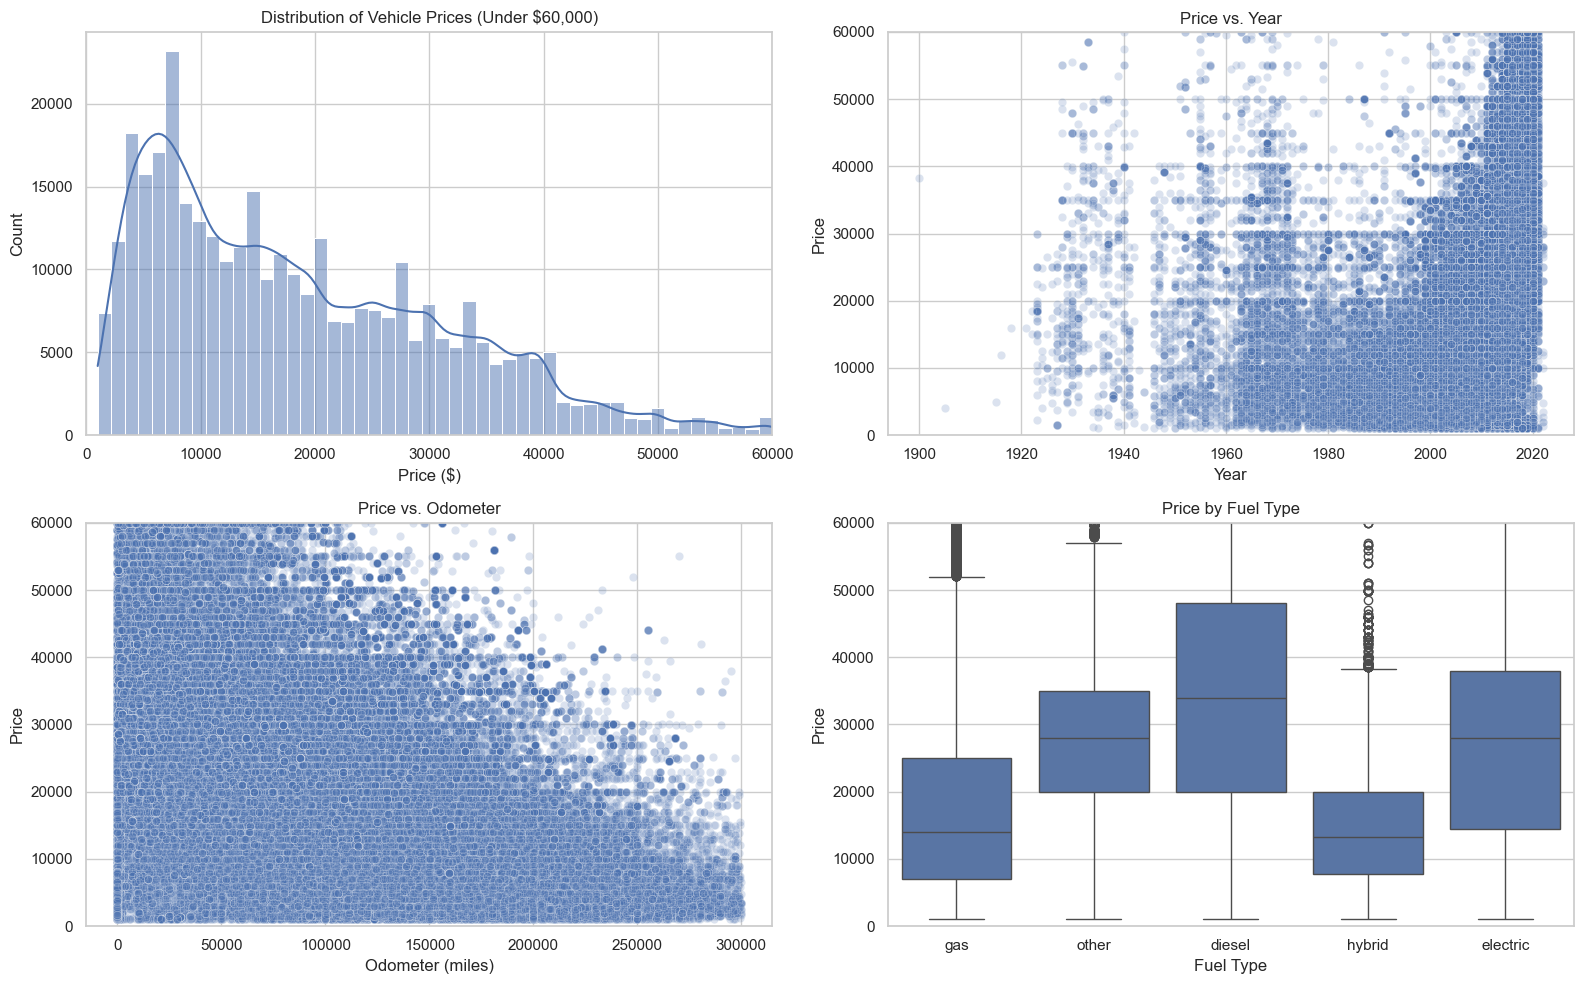

In [17]:
sns.set(style="whitegrid")
plt.figure(figsize=(16, 10))


# 1. Price Distribution
filtered_df = data_clean[data_clean['price'] < 60000]
plt.subplot(2, 2, 1)
sns.histplot(data=filtered_df, x='price', bins=50, kde=True)
plt.title('Distribution of Vehicle Prices (Under $60,000)')
plt.xlabel('Price ($)')
plt.xlim(0, 60000)

# 2. Price vs. Year
plt.subplot(2, 2, 2)
sns.scatterplot(x='year', y='price', data=data_clean, alpha=0.2)
plt.title("Price vs. Year")
plt.xlabel("Year")
plt.ylabel("Price")
plt.ylim(0, 60000)

# 3. Price vs. Odometer
odometer_filtered_df = data_clean[data_clean['odometer'] < 300000]
plt.subplot(2, 2, 3)
sns.scatterplot(x='odometer', y='price', data=odometer_filtered_df, alpha=0.2)
plt.title("Price vs. Odometer")
plt.xlabel("Odometer (miles)")
plt.ylabel("Price")
plt.ylim(0, 60000)

# 4. Boxplot: Price by Fuel Type
plt.subplot(2, 2, 4)
sns.boxplot(x='fuel', y='price', data=data_clean)
plt.title("Price by Fuel Type")
plt.xlabel("Fuel Type")
plt.ylabel("Price")
plt.ylim(0, 60000)

plt.tight_layout()
plt.show()


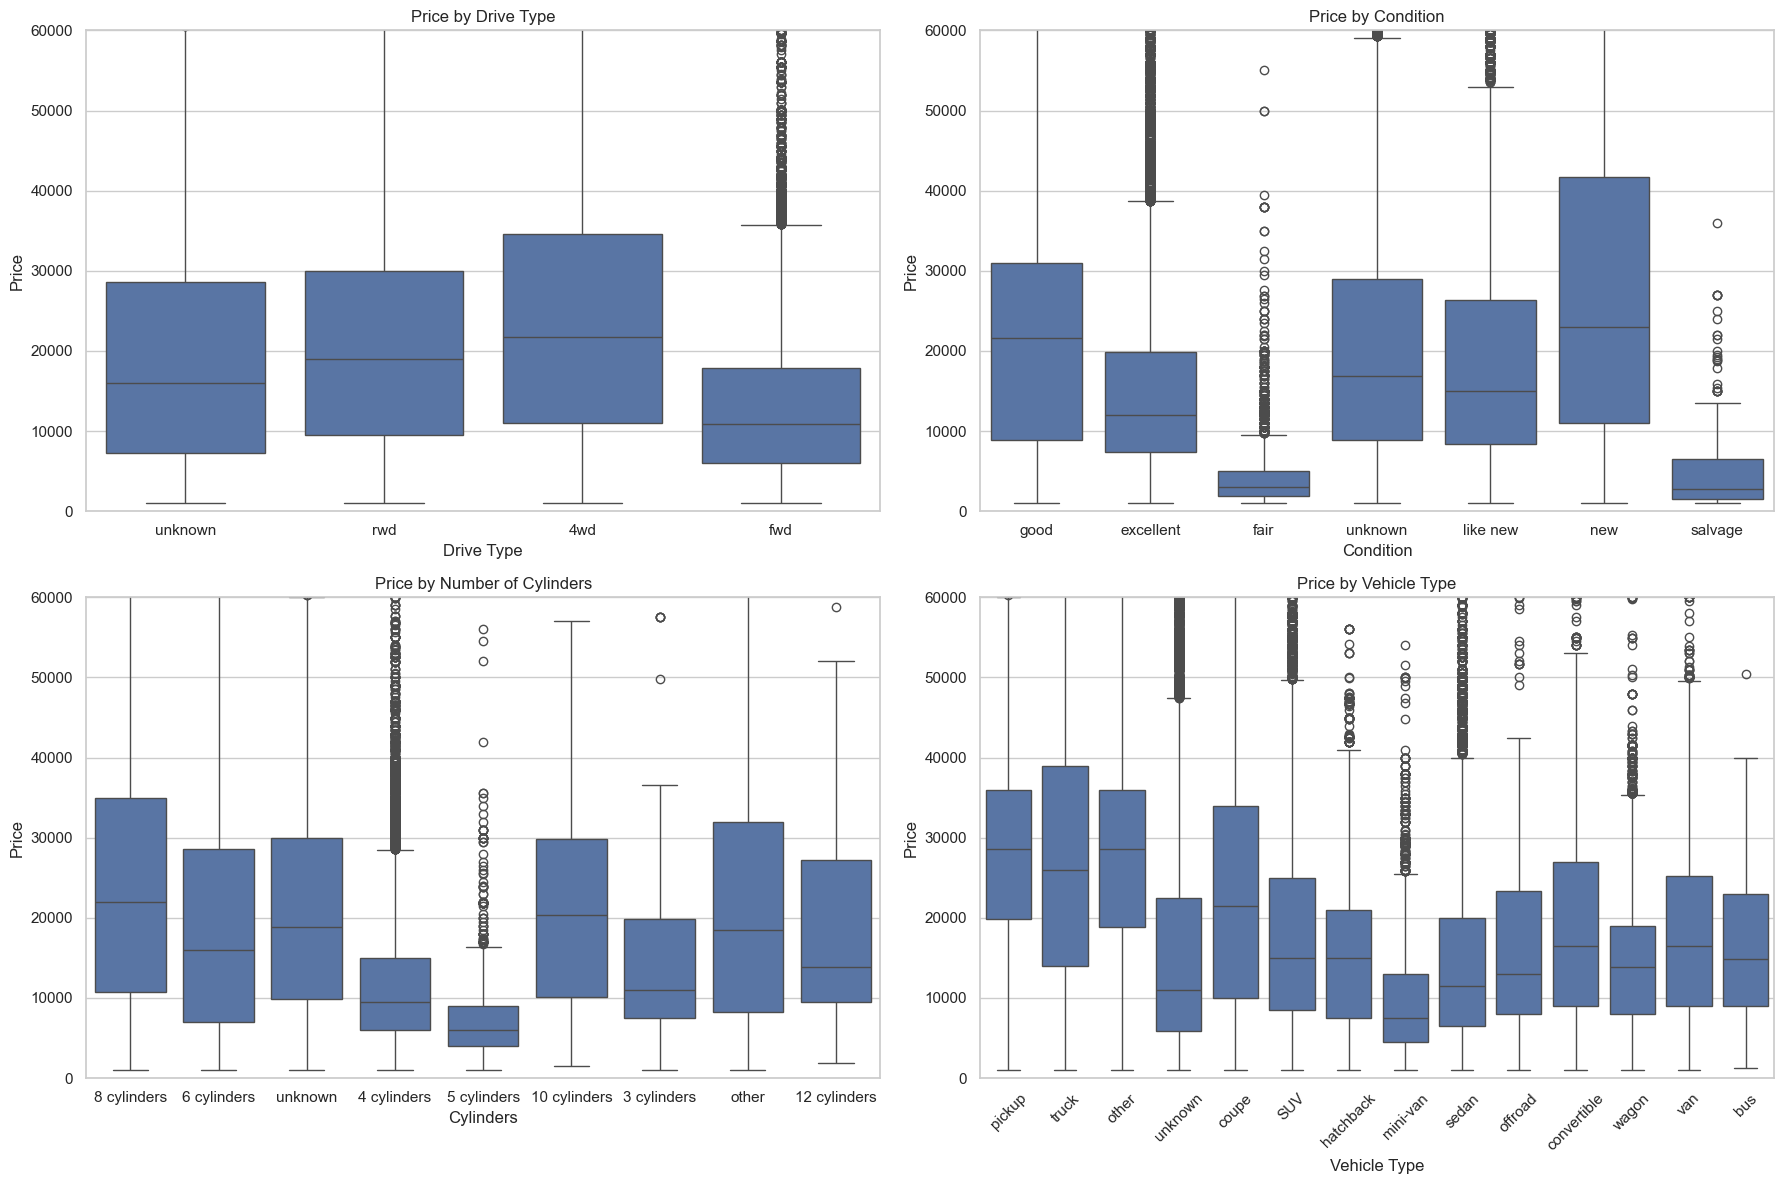

In [19]:
# Additional boxplots for categorical variables vs. price

plt.figure(figsize=(18, 12))

# Boxplot: Price by Drive Type
plt.subplot(2, 2, 1)
sns.boxplot(x='drive', y='price', data=data_clean)
plt.title("Price by Drive Type")
plt.xlabel("Drive Type")
plt.ylabel("Price")
plt.ylim(0, 60000)

# Boxplot: Price by Vehicle Condition
plt.subplot(2, 2, 2)
sns.boxplot(x='condition', y='price', data=data_clean)
plt.title("Price by Condition")
plt.xlabel("Condition")
plt.ylabel("Price")
plt.ylim(0, 60000)

# Boxplot: Price by Cylinders
plt.subplot(2, 2, 3)
sns.boxplot(x='cylinders', y='price', data=data_clean)
plt.title("Price by Number of Cylinders")
plt.xlabel("Cylinders")
plt.ylabel("Price")
plt.ylim(0, 60000)

# Boxplot: Price by Vehicle Type
plt.subplot(2, 2, 4)
sns.boxplot(x='type', y='price', data=data_clean)
plt.title("Price by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.ylim(0, 60000)

plt.tight_layout()
plt.show()

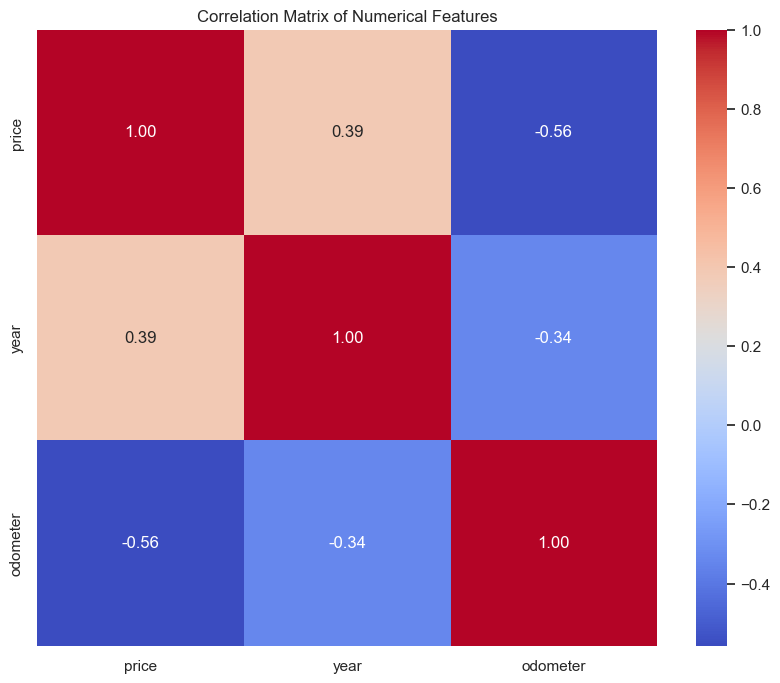

In [21]:
numerical_df = data_clean.select_dtypes(include=np.number)

plt.figure(figsize=(10, 8))
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [23]:
# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()


In [25]:
# Define transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


## 4. Modeling
Focusing on price, we'll look at some of the other features (year, manufacurer, model, condition, cylinders, fuel, odometer, title_status, transmission, drive, type, and paint_color) and compare several models: 

* Linear Regression (baseline model)
* Ridge
* Lasso
* SVR
* KNN Regressor
* Random Forest Regressor
* XGBoost

We'll also perform cross-validation on the models and use GridSearchCV for hyperparameter tuning.

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

linear_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'odometer']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['manufacturer', 'condition',
                                                   'cylinders', 'fuel',
                                                   'title_status',
                                                   'transmission', 'drive',
                                                   'type', 'state'])])),
                ('regressor', LinearRegression())])

In [33]:
predictions = linear_pipeline.predict(X_test)
linear_rmse = root_mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Root Mean Squared Error: {linear_rmse:.2f}")
print(f"R² Score: {r2:.2f}")


Root Mean Squared Error: 8446.56
R² Score: 0.65


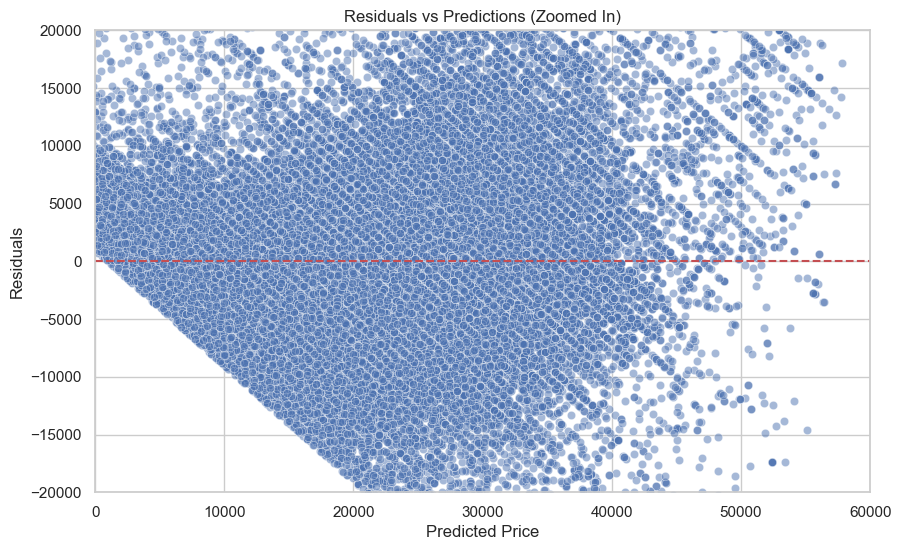

In [35]:
# Recalculate residuals
predictions = linear_pipeline.predict(X_test)
residuals = y_test - predictions

# Plot with limits to zoom in
plt.figure(figsize=(10, 6))
sns.scatterplot(x=predictions, y=residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predictions (Zoomed In)')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')

# Focus on central cluster
plt.ylim(-20000, 20000)
plt.xlim(0, 60000)
plt.show()


In [37]:
# List of models
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor(),
    'RandomForest': RandomForestRegressor(n_jobs=-1, random_state=42)
}

In [39]:
# Create a new pipeline for Ridge
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

# Train Ridge model
ridge_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'odometer']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['manufacturer', 'condition',
                                                   'cylinders', 'fuel',
                                                   'title_status',
                                                   'transmission', 'drive',
                                                   'type', 'state'])])),
                ('regressor', Ridge())])

In [41]:
# Predict and evaluate
ridge_preds = ridge_pipeline.predict(X_test)
ridge_rmse = root_mean_squared_error(y_test, ridge_preds)
print(f"Ridge RMSE: {ridge_rmse:,.2f}")

Ridge RMSE: 8,446.46


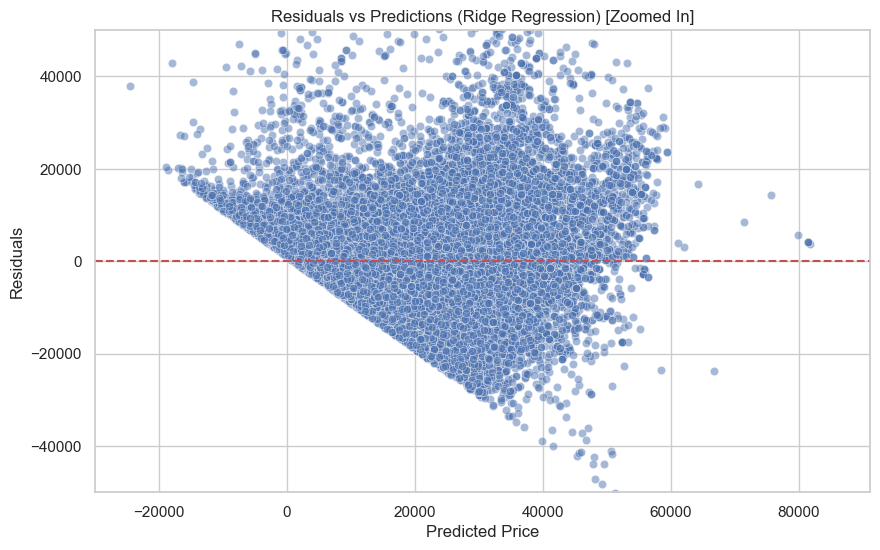

In [43]:
# Predict using Ridge
ridge_preds = ridge_pipeline.predict(X_test)
ridge_residuals = y_test - ridge_preds

# Plot residuals vs. predicted
plt.figure(figsize=(10, 6))
mask = ridge_preds < 100000
sns.scatterplot(x=ridge_preds[mask], y=ridge_residuals[mask], alpha=0.5)
# sns.scatterplot(x=ridge_preds, y=ridge_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.ylim(-50000, 50000)  # Zoom into this vertical range
# plt.xscale('log')
plt.title('Residuals vs Predictions (Ridge Regression) [Zoomed In]')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.show()


In [45]:
X_train_small = X_train[:5000]
y_train_small = y_train[:5000]

# Create a pipeline with Lasso Regression
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=0.1, max_iter=10000, random_state=42))
])

# Train Lasso model
lasso_pipeline.fit(X_train_small, y_train_small)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'odometer']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['manufacturer', 'condition',
                                                   'cylinders', 'fuel',
                                                   'title_status',
                                                   'transmission', 'drive',
                                                   'type', 'state'])])),
                ('regressor',
                 Lasso(alpha=0.1, max_iter=10000, random_state=42))])

In [47]:
# Predict and evaluate
lasso_preds = lasso_pipeline.predict(X_test)
lasso_rmse = root_mean_squared_error(y_test, lasso_preds)

print(f"Lasso RMSE: {lasso_rmse:,.2f}")

Lasso RMSE: 8,593.16


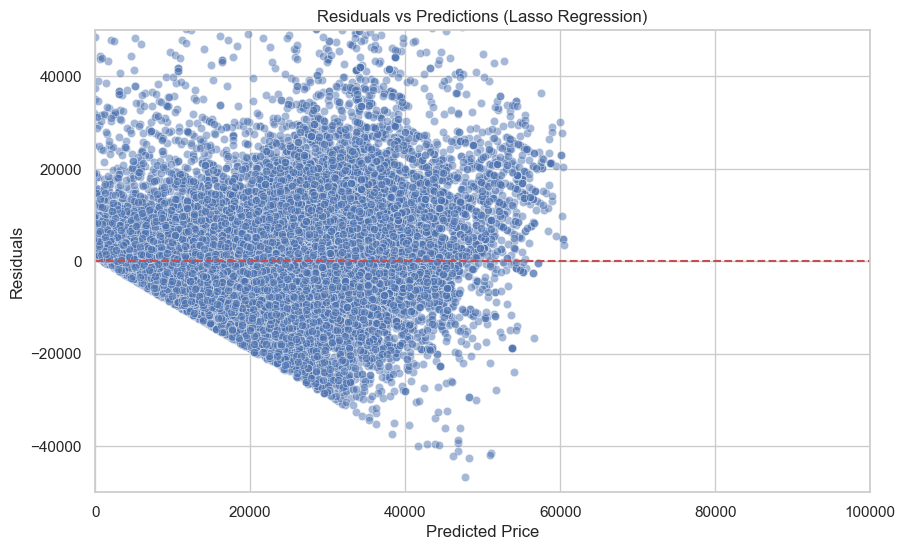

In [49]:
lasso_residuals = y_test - lasso_preds

plt.figure(figsize=(10, 6))
sns.scatterplot(x=lasso_preds, y=lasso_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predictions (Lasso Regression)')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.ylim(-50000, 50000)
plt.xlim(0, 100000)  # Optional: adjust based on your data
plt.show()


[Back to Top](#top)

In [51]:
# Create a pipeline with XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

# Train XGBoost model
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'odometer']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['manufacturer', 'condition',
                                                   'cylinders', 'fuel',
                                                   'title_status',
                                                   'transmission', 'drive',
                                                   'type', 'state'])])),
                ('regressor',
                 XGBRegressor(base_...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [53]:
# Predict and evaluate
xgb_preds = xgb_pipeline.predict(X_test)
xgb_rmse = root_mean_squared_error(y_test, xgb_preds)

print(f"XGBoost RMSE: {xgb_rmse:,.2f}")

XGBoost RMSE: 6,021.58


In [55]:
# Limit training size to speed up SVR
sample_size = 5000

X_train_small = X_train[:sample_size]
y_train_small = y_train[:sample_size]

svr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR(C=1.0, epsilon=0.2))  
])

svr_pipeline.fit(X_train_small, y_train_small)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'odometer']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['manufacturer', 'condition',
                                                   'cylinders', 'fuel',
                                                   'title_status',
                                                   'transmission', 'drive',
                                                   'type', 'state'])])),
                ('regressor', SVR(epsilon=0.2))])

In [57]:
svr_preds = svr_pipeline.predict(X_test)
svr_rmse = root_mean_squared_error(y_test, svr_preds)
print(f"SVR RMSE: {svr_rmse:,.2f}")

SVR RMSE: 14,629.29


In [59]:
X_train_small = X_train[:5000]
y_train_small = y_train[:5000]

knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(n_neighbors=5))
])

knn_pipeline.fit(X_train_small, y_train_small)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'odometer']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['manufacturer', 'condition',
                                                   'cylinders', 'fuel',
                                                   'title_status',
                                                   'transmission', 'drive',
                                                   'type', 'state'])])),
                ('regressor', KNeighborsRegressor())])

In [61]:
knn_preds = knn_pipeline.predict(X_test)
knn_rmse = root_mean_squared_error(y_test, knn_preds)
print(f"KNN RMSE: {knn_rmse:,.2f}")

KNN RMSE: 7,664.70


In [63]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=30, random_state=42, n_jobs=-1))
])

rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'odometer']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['manufacturer', 'condition',
                                                   'cylinders', 'fuel',
                                                   'title_status',
                                                   'transmission', 'drive',
                                                   'type', 'state'])])),
                ('regressor',
                 RandomForestRegressor(n_estimators=30, n_jobs=-1,
                                       random_state=42))])

In [65]:
rf_preds = rf_pipeline.predict(X_test)
rf_rmse = root_mean_squared_error(y_test, rf_preds)
print(f"Random Forest RMSE: {rf_rmse:,.2f}")

Random Forest RMSE: 4,294.89


In [67]:
comparison_df = pd.DataFrame({
    'Model': [
        "Linear Regression",
        "Ridge Regression",
        "Lasso Regression (Subset)",
        "SVR (Subset)",
        "KNN (Subset)",
        "Random Forest",
        "XGBoost"
    ],
    'RMSE': [
        linear_rmse, 
        ridge_rmse, 
        lasso_rmse, 
        svr_rmse,  
        knn_rmse, 
        rf_rmse, 
        xgb_rmse  
    ]
})

comparison_df = comparison_df.sort_values(by='RMSE')

display(comparison_df)


,Model,RMSE
5,Random Forest,4294.889751
6,XGBoost,6021.576762
4,KNN (Subset),7664.704070
1,Ridge Regression,8446.462990
0,Linear Regression,8446.556573
2,Lasso Regression (Subset),8593.164479
3,SVR (Subset),14629.288061


In [69]:
# Define parameter grid
rf_param_grid = {
    'regressor__n_estimators': [10, 30],
    'regressor__max_depth': [10, 20],
    'regressor__min_samples_split': [2, 5]
}

# Create pipeline
rf_pipeline_base = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Grid search with cross-validation
rf_grid = GridSearchCV(
    rf_pipeline_base,
    rf_param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

# Best result
print(f"Best RMSE from Grid Search: {-rf_grid.best_score_:,.2f}")
print("Best Parameters:", rf_grid.best_params_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best RMSE from Grid Search: 5,081.11
Best Parameters: {'regressor__max_depth': 20, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 30}


In [71]:
# Define grid for XGBoost
xgb_param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [3, 6],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__subsample': [0.8, 1.0]
}

# XGBoost pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42, n_jobs=-1, verbosity=0))
])

# GridSearchCV setup
xgb_grid = GridSearchCV(
    xgb_pipeline,
    xgb_param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit
xgb_grid.fit(X_train, y_train)

# Best result
print(f"Best RMSE from Grid Search (XGBoost): {-xgb_grid.best_score_:,.2f}")
print("Best Parameters:", xgb_grid.best_params_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best RMSE from Grid Search (XGBoost): 5,987.07
Best Parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 6, 'regressor__n_estimators': 100, 'regressor__subsample': 0.8}


Random Forest RMSE: 4,421.19
Best RF Params: {'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}

XGBoost RMSE: 5,921.26
Best XGB Params: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 6, 'regressor__n_estimators': 100, 'regressor__subsample': 0.8}


In [73]:
cv_results_df = pd.DataFrame({
    'Model': ['Random Forest (CV)', 'XGBoost (CV)'],
    'Best RMSE': [-rf_grid.best_score_, -xgb_grid.best_score_],
    'Best Params': [rf_grid.best_params_, xgb_grid.best_params_]
})

cv_results_df = cv_results_df.sort_values(by='Best RMSE')
display(cv_results_df)


,Model,Best RMSE,Best Params
0,Random Forest (CV),5081.106017,"{'regressor__max_depth': 20, 'regressor__min_s..."
1,XGBoost (CV),5987.067194,"{'regressor__learning_rate': 0.1, 'regressor__..."


[Back to Top](#top)

## 5. Evaulation
* Use RMSE and R^2 to compare models
* Linear model coefficient
* Permutation importance (for trees, SVR, KNN)
* visual comparison of predicted vs actual prices

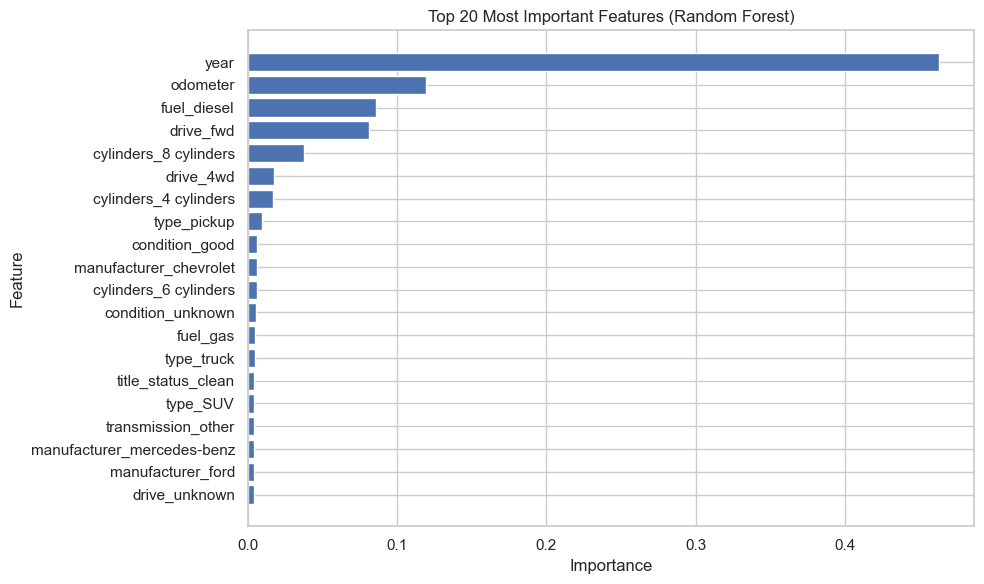

In [77]:
# Get fitted pipeline
best_rf = rf_grid.best_estimator_

# Get feature names after preprocessing
ohe = best_rf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
ohe_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = numeric_features + ohe_feature_names.tolist()

# Get feature importances
importances = best_rf.named_steps['regressor'].feature_importances_

# Create DataFrame
feat_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_df['Feature'][::-1], feat_df['Importance'][::-1])
plt.title('Top 20 Most Important Features (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [79]:
y_pred = rf_grid.best_estimator_.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Final Model RMSE: {rmse:,.2f}")
print(f"Final Model R²: {r2:.2f}")


Final Model RMSE: 4,986.30
Final Model R²: 0.88


[Back to Top](#top)

## 6. Deployment


In [ ]:
# import joblib
# joblib.dump(rf_grid.best_estimator_, 'final_rf_model.pkl')

['final_rf_model.pkl']

## Findings ##

### Business Problem ###

Used car dealerships want to know what features drive price and which vehicles to prioritize in inventory



### Data Used ###
* ~300,000 listings from vehicles.csv
  
* Cleaned, reduced high-cardinality features
  
* Target: price.



### Modeling Summary ###
* Tested 7 regression models using pipelines

* Performed grid search with cross-validation

* Metric: Root Mean Squared Error (RMSE)


### Best Model ###
* Random Forest Regressor

* RMSE (CV): $4,421.19

* Parameters: 100 trees, no depth limit, default split



### Top Predictive Features ###
* Odometer: Lower mileage commands more money

* Year: Due to depreciation, newer cars are usually more expensive

* Manufacturer

* Title Status

* Transmission



### Business Insights ###
* Focus on low-mileage, newer vehicles with clean titles

* Vehicles from top-performing manufacturers command higher value

* Automatics and 4WDs tend to predict higher price brackets


[Back to Top](#top)

## 7. Recommendations
* Prioritize new and low-mileage cars — achieve higher resale prices

* Stock more diesel or electric vehicles as they attract premium prices as well

* Have SUVs and trucks 

### Next Steps ###
* Conduct a time-based trend analysis to see if prices seasonally affected

* Explore cluster analysis to segment buyer behavior

* Create alerts for undervalued vehicles



[Back to Top](#top)